In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import SpatialGlue
import skmisc
import numpy as np

In [2]:
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.5.1"

Device: cpu


In [3]:
file_fold = r"D:\SpatialGlue\dataset"

In [4]:
# read data 1
rna_df_1 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_100_RNA.csv")
adt_df_1 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_100_ADT.csv")
meta_df_1 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_100_metadata.csv")

In [5]:
# read data 2
rna_df_2 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_1000_RNA.csv")
adt_df_2 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_1000_ADT.csv")
meta_df_2 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_1000_metadata.csv")

In [6]:
# read data 3
rna_df_3 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_100_RNA.csv")
adt_df_3 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_100_ADT.csv")
meta_df_3 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_100_metadata.csv")

In [7]:
# read data 4
rna_df_4 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_1000_RNA.csv")
adt_df_4 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_1000_ADT.csv")
meta_df_4 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_1000_metadata.csv")

In [8]:
def create_adata(rna_df, adt_df, meta_df):
    adata_rna = sc.AnnData(X = rna_df.values, obs = meta_df, var = pd.DataFrame(index = rna_df.columns), dtype = "float32")
    adata_adt = sc.AnnData(X = adt_df.values, obs = meta_df, var = pd.DataFrame(index = adt_df.columns), dtype = "float32")

    assert (rna_df.index == meta_df.index).all()
    assert (adt_df.index == meta_df.index).all()
    
    adata_rna.var_names_make_unique()
    adata_adt.var_names_make_unique()
    
    adata_rna.obsm['spatial'] = adata_rna.obs[['X','Y']].to_numpy()
    adata_adt.obsm['spatial'] = adata_adt.obs[['X','Y']].to_numpy()

    return adata_rna, adata_adt

In [9]:
adata_rna_1, adata_adt_1 = create_adata(rna_df = rna_df_1, adt_df = adt_df_1, meta_df = meta_df_1)
adata_rna_2, adata_adt_2 = create_adata(rna_df = rna_df_2, adt_df = adt_df_2, meta_df = meta_df_2)
adata_rna_3, adata_adt_3 = create_adata(rna_df = rna_df_3, adt_df = adt_df_3, meta_df = meta_df_3)
adata_rna_4, adata_adt_4 = create_adata(rna_df = rna_df_4, adt_df = adt_df_4, meta_df = meta_df_4)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
# Specify data type
data_type = '10x'

# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 42
fix_seed(random_seed)

In [17]:
#real data
real_data = sc.read_h5ad(r"D:\SpatialGlue\dataset\adata_all_human_lymph_node_A1.h5ad")

rna_df_real = real_data.obsm['RNA_feat']
adt_df_real = real_data.obsm['Pro_feat']

adata_rna_real = sc.AnnData(X = rna_df_real, obs = real_data.obs)
adata_adt_real = sc.AnnData(X = adt_df_real, obs = real_data.obs)
adata_rna_real.obsm['spatial'] = real_data.obsm['spatial']
adata_adt_real.obsm['spatial'] = real_data.obsm['spatial']

In [12]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca

def preprocess(adata_rna, adata_adt):
    # RNA
    sc.pp.filter_genes(adata_rna, min_cells=10)
    sc.pp.highly_variable_genes(adata_rna, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata_rna, target_sum=1e4)
    sc.pp.log1p(adata_rna)
    sc.pp.scale(adata_rna)
    
    adata_rna_high =  adata_rna[:, adata_rna.var['highly_variable']]
    adata_rna.obsm['feat'] = pca(adata_rna_high, n_comps=adata_adt.n_vars-1)

    # Protein
    adata_adt = clr_normalize_each_cell(adata_adt)
    sc.pp.scale(adata_adt)
    adata_adt.obsm['feat'] = pca(adata_adt, n_comps=adata_adt.n_vars-1)

    return adata_rna, adata_adt

In [13]:
adata_rna_1, adata_adt_1 = preprocess(adata_rna_1, adata_adt_1)
adata_rna_2, adata_adt_2 = preprocess(adata_rna_2, adata_adt_2)
adata_rna_3, adata_adt_3 = preprocess(adata_rna_3, adata_adt_3)
adata_rna_4, adata_adt_4 = preprocess(adata_rna_4, adata_adt_4)

In [14]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca

def preprocess_real(adata_rna, adata_adt):
    # RNA
    adata_rna.obsm['feat'] = pca(adata_rna, n_comps=adata_adt.n_vars-1)

    # Protein
    adata_adt.obsm['feat'] = pca(adata_adt, n_comps=adata_adt.n_vars-1)

    return adata_rna, adata_adt

In [18]:
adata_rna_real, adata_rna_adt = preprocess_real(adata_rna_real, adata_adt_real)

In [19]:
from SpatialGlue.preprocess import construct_neighbor_graph
data_1 = construct_neighbor_graph(adata_rna_1, adata_adt_1, datatype=data_type)
data_2 = construct_neighbor_graph(adata_rna_2, adata_adt_2, datatype=data_type)
data_3 = construct_neighbor_graph(adata_rna_3, adata_adt_3, datatype=data_type)
data_4 = construct_neighbor_graph(adata_rna_4, adata_adt_4, datatype=data_type)
data_real = construct_neighbor_graph(adata_rna_real, adata_adt_real, datatype=data_type)

In [21]:
def reconstruct_adata(adata_rna, output):
    adata = adata_rna.copy()
    adata.obsm['emb_latent_rna'] = output['emb_latent_omics1'].copy()
    adata.obsm['emb_latent_adt'] = output['emb_latent_omics2'].copy()
    adata.obsm['SpatialGlue'] = output['SpatialGlue'].copy()
    adata.obsm['alpha'] = output['alpha']
    adata.obsm['alpha_rna'] = output['alpha_omics1']
    adata.obsm['alpha_adt'] = output['alpha_omics2']
    return adata

### Data 1: Amplify_CBMCs_nCells_1992_nGenes_100

In [20]:
# define model
from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
model_1 = Train_SpatialGlue(data_1, datatype=data_type, device=device)

# train model
output_1 = model_1.train()

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\SpatialGlue\preprocess.py:132: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:623.)
  return torch.sparse.FloatTensor(indices, values, shape)
  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\SpatialGlue\model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.01it/s]

Model training finished!



In [22]:
adata_1 = reconstruct_adata(adata_rna = adata_rna_1, output = output_1)

In [23]:
# Define the number of clusters
num_cluster_1 = len(adata_1.obs['label'].unique())

# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata_1, key='SpatialGlue', add_key='SpatialGlue', n_clusters = num_cluster_1, method=tool, use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


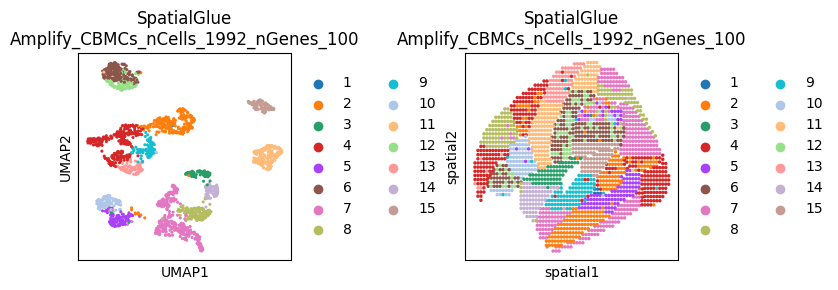

In [24]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(8, 3))
sc.pp.neighbors(adata_1, use_rep='SpatialGlue', n_neighbors=10)
sc.tl.umap(adata_1)

sc.pl.umap(adata_1, color='SpatialGlue', ax=ax_list[0], title=f'SpatialGlue\nAmplify_CBMCs_nCells_1992_nGenes_100', s=20, show=False)
sc.pl.embedding(adata_1, basis='spatial', color='SpatialGlue', ax=ax_list[1], title=f'SpatialGlue\nAmplify_CBMCs_nCells_1992_nGenes_100', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

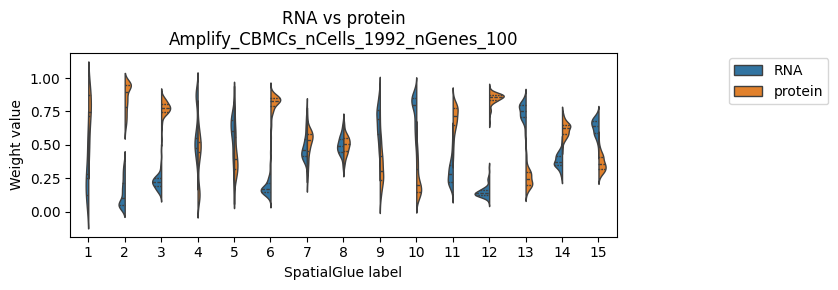

In [25]:
# plotting modality weight values.
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata_1.obsm['alpha'][:, 0], adata_1.obsm['alpha'][:, 1]
df['label'] = adata_1.obs['SpatialGlue'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title(f'RNA vs protein\nAmplify_CBMCs_nCells_1992_nGenes_100')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()

In [27]:
dataset = 'Amplify_CBMCs_nCells_1992_nGenes_100'

In [29]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata_1.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = adata_1.obs['SpatialGlue']

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append(['SpatialGlue', dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['Method', 'DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.3452
NMI: 0.6169
HOM: 0.6025


### Data 2: Amplify_CBMCs_nCells_1992_nGenes_1000

In [30]:
dataset = 'Amplify_CBMCs_nCells_1992_nGenes_1000'

In [31]:
model_2 = Train_SpatialGlue(data_2, datatype = data_type, device = device)
output_2 = model_2.train()

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\SpatialGlue\model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.19it/s]

Model training finished!



In [32]:
adata_2 = reconstruct_adata(adata_rna = adata_rna_2, output = output_2)

In [33]:
num_cluster_2 = len(adata_2.obs['label'].unique())

# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata_2, key='SpatialGlue', add_key='SpatialGlue', n_clusters = num_cluster_2, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


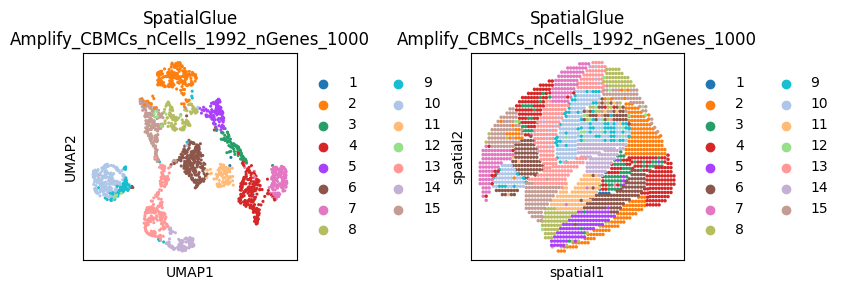

In [34]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(8, 3))
sc.pp.neighbors(adata_2, use_rep='SpatialGlue', n_neighbors=10)
sc.tl.umap(adata_2)

sc.pl.umap(adata_2, color='SpatialGlue', ax=ax_list[0], title=f'SpatialGlue\n{dataset}', s=20, show=False)
sc.pl.embedding(adata_2, basis='spatial', color='SpatialGlue', ax=ax_list[1], title=f'SpatialGlue\n{dataset}', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

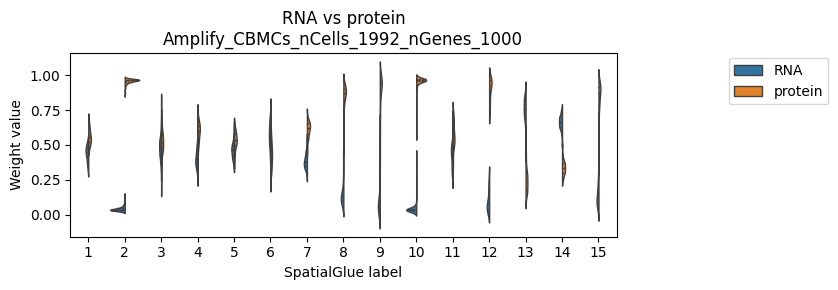

In [36]:
# plotting modality weight values.
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata_2.obsm['alpha'][:, 0], adata_2.obsm['alpha'][:, 1]
df['label'] = adata_2.obs['SpatialGlue'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title(f'RNA vs protein\n{dataset}')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()

In [37]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata_2.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = adata_2.obs['SpatialGlue']

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append(['SpatialGlue', dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['Method', 'DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.3532
NMI: 0.5999
HOM: 0.5883


### Data 3: Amplify_CBMCs_nCells_5024_nGenes_100

In [38]:
dataset = 'Amplify_CBMCs_nCells_5024_nGenes_100'

In [39]:
model_3 = Train_SpatialGlue(data_3, datatype = data_type, device = device)
output_3 = model_3.train()

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\SpatialGlue\model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:59<00:00,  3.36it/s]


Model training finished!



In [40]:
adata_3 = reconstruct_adata(adata_rna = adata_rna_3, output = output_3)

In [41]:
num_cluster_3 = len(adata_3.obs['label'].unique())

# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata_3, key='SpatialGlue', add_key='SpatialGlue', n_clusters= num_cluster_3, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


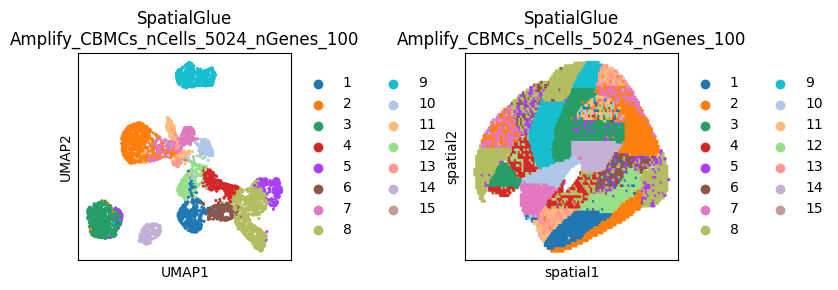

In [42]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(8, 3))
sc.pp.neighbors(adata_3, use_rep='SpatialGlue', n_neighbors=num_cluster_3)
sc.tl.umap(adata_3)

sc.pl.umap(adata_3, color='SpatialGlue', ax=ax_list[0], title=f'SpatialGlue\n{dataset}', s=20, show=False)
sc.pl.embedding(adata_3, basis='spatial', color='SpatialGlue', ax=ax_list[1], title=f'SpatialGlue\n{dataset}', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

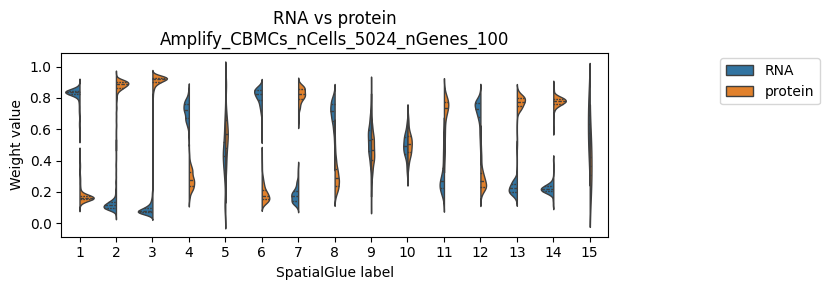

In [43]:
# plotting modality weight values.
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata_3.obsm['alpha'][:, 0], adata_3.obsm['alpha'][:, 1]
df['label'] = adata_3.obs['SpatialGlue'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title(f'RNA vs protein\n{dataset}')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()

In [44]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata_3.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = adata_3.obs['SpatialGlue']

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append(['SpatialGlue', dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['Method', 'DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.3315
NMI: 0.5755
HOM: 0.5608


### Data 4: Amplify_CBMCs_nCells_5024_nGenes_1000

In [45]:
dataset = 'Amplify_CBMCs_nCells_5024_nGenes_1000'

In [60]:
model_4 = Train_SpatialGlue(data_4, datatype = data_type, device = device)
output_4 = model_4.train()

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\SpatialGlue\model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:49<00:00,  4.07it/s]

Model training finished!



In [61]:
adata_4 = reconstruct_adata(adata_rna = adata_rna_4, output = output_4)

In [63]:
num_cluster_4 = len(adata_4.obs['label'].unique())

# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata_4, key='SpatialGlue', add_key='SpatialGlue', n_clusters= num_cluster_4, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


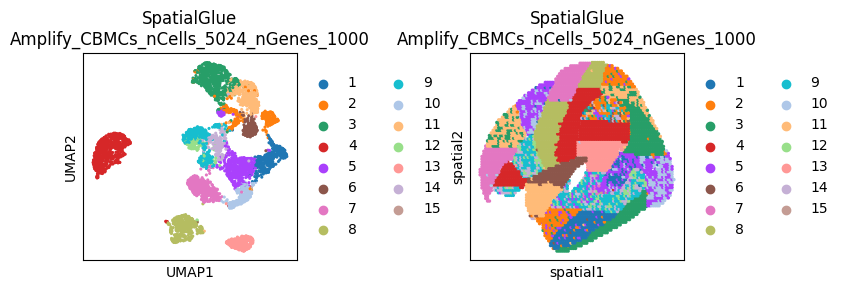

In [65]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(8, 3))
sc.pp.neighbors(adata_4, use_rep='SpatialGlue', n_neighbors=num_cluster_4)
sc.tl.umap(adata_4)

sc.pl.umap(adata_4, color='SpatialGlue', ax=ax_list[0], title=f'SpatialGlue\n{dataset}', s=20, show=False)
sc.pl.embedding(adata_4, basis='spatial', color='SpatialGlue', ax=ax_list[1], title=f'SpatialGlue\n{dataset}', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

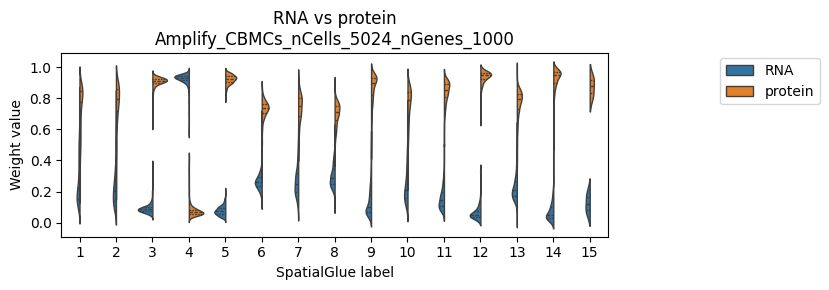

In [66]:
# plotting modality weight values.
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata_4.obsm['alpha'][:, 0], adata_4.obsm['alpha'][:, 1]
df['label'] = adata_4.obs['SpatialGlue'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title(f'RNA vs protein\n{dataset}')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()

In [67]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata_4.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = adata_4.obs['SpatialGlue']

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append(['SpatialGlue', dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['Method', 'DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.3289
NMI: 0.5645
HOM: 0.5547


### Data 5: Real Data

In [68]:
dataset = 'Real Data'

In [69]:
model_5 = Train_SpatialGlue(data_real, datatype = data_type, device = device)
output_5 = model_5.train()

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\SpatialGlue\model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:44<00:00,  4.45it/s]

Model training finished!



In [70]:
adata_real = reconstruct_adata(adata_rna = adata_rna_real, output = output_5)

Ground truth label - Level 0

In [72]:
num_cluster_real_0 = len(adata_real.obs['true_label_level_0'].unique())

# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata_real, key='SpatialGlue', add_key='SpatialGlue', n_clusters= num_cluster_real_0, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


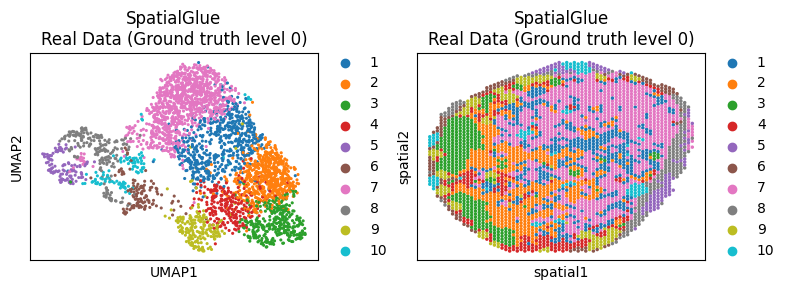

In [74]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(8, 3))
sc.pp.neighbors(adata_real, use_rep='SpatialGlue', n_neighbors=num_cluster_real_0)
sc.tl.umap(adata_real)

sc.pl.umap(adata_real, color='SpatialGlue', ax=ax_list[0], title=f'SpatialGlue\n{dataset} (Ground truth level 0)', s=20, show=False)
sc.pl.embedding(adata_real, basis='spatial', color='SpatialGlue', ax=ax_list[1], title=f'SpatialGlue\n{dataset} (Ground truth level 0)', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

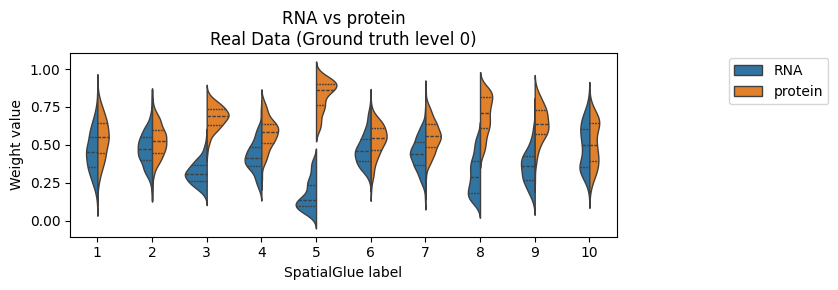

In [76]:
# plotting modality weight values.
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata_real.obsm['alpha'][:, 0], adata_real.obsm['alpha'][:, 1]
df['label'] = adata_real.obs['SpatialGlue'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title(f'RNA vs protein\n{dataset} (Ground truth level 0)')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()

In [78]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata_real.obs['true_label_level_0'].values   # numpy array

# Predicted cluster labels
labels_pred = adata_real.obs['SpatialGlue']

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append(['SpatialGlue', f"{dataset} (Level 0)", ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['Method', 'DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.2595
NMI: 0.3787
HOM: 0.4147


Ground truth label - Level 1

In [79]:
num_cluster_real_1 = len(adata_real.obs['true_label_level_1'].unique())

# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata_real, key='SpatialGlue', add_key='SpatialGlue', n_clusters= num_cluster_real_1, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


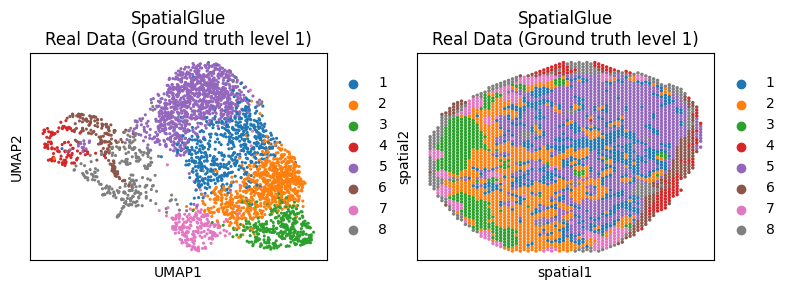

In [82]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(8, 3))
sc.pp.neighbors(adata_real, use_rep='SpatialGlue', n_neighbors=num_cluster_real_1)
sc.tl.umap(adata_real)

sc.pl.umap(adata_real, color='SpatialGlue', ax=ax_list[0], title=f'SpatialGlue\n{dataset} (Ground truth level 1)', s=20, show=False)
sc.pl.embedding(adata_real, basis='spatial', color='SpatialGlue', ax=ax_list[1], title=f'SpatialGlue\n{dataset} (Ground truth level 1)', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

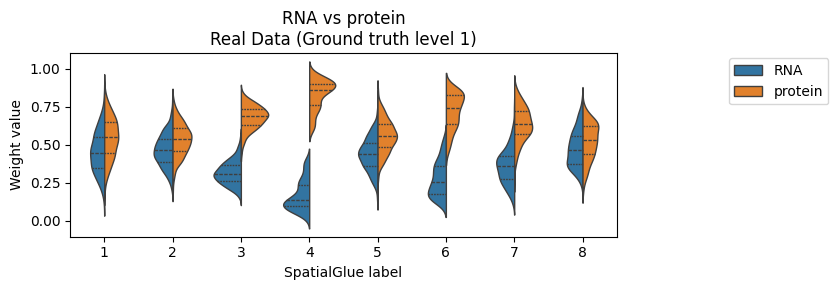

In [83]:
# plotting modality weight values.
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata_real.obsm['alpha'][:, 0], adata_real.obsm['alpha'][:, 1]
df['label'] = adata_real.obs['SpatialGlue'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title(f'RNA vs protein\n{dataset} (Ground truth level 1)')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()

In [84]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata_real.obs['true_label_level_1'].values   # numpy array

# Predicted cluster labels
labels_pred = adata_real.obs['SpatialGlue']

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append(['SpatialGlue', f"{dataset} (Level 1)", ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['Method', 'DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.2543
NMI: 0.3725
HOM: 0.4632


ValueError: keyword ha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_contains', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

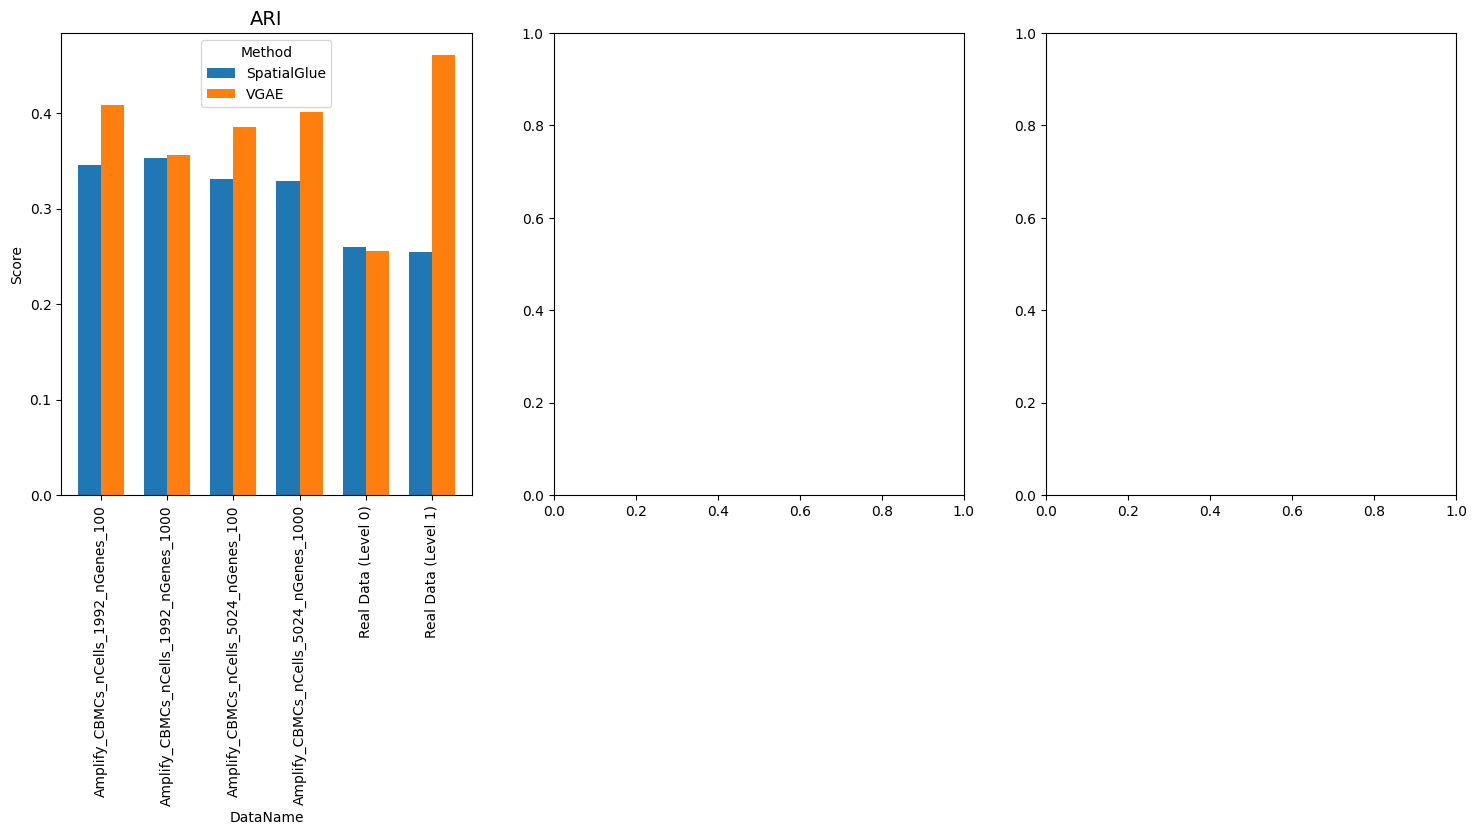

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('result.csv')

# Plotting
metrics = ["ARI", "NMI", "HOM"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    df_pivot = df.pivot(index="DataName", columns="Method", values=metric)
    df_pivot.plot(kind="bar", ax=ax, width=0.7)
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel("Score")
    ax.set_xlabel("DataName")
    ax.legend(title="Method")
    ax.tick_params(axis="x", rotation=45, ha="right")

plt.tight_layout()
plt.show()
